#Import Packages

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install anndata
# !pip install celltypist
# !pip install scanpy

In [ ]:
import os
os.environ["SCIPY_ARRAY_API"] = "1"
os.environ["SKLEARN_ARRAY_API"] = "1"
import anndata
import numpy as np
import celltypist
from celltypist import models
import time
import scanpy as sc
from scipy import sparse
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/usr/local/lib/python3.12/dist-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/usr/local/lib/python3.12/dist-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


#Functions

In [ ]:
from sklearn.neighbors import kneighbors_graph
def SelfGraphConv(adata, n_neighbors = 4):
    connectivity = kneighbors_graph(adata.obsm['spatial'], n_neighbors=n_neighbors, include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T)
    adata.X = connectivity.dot(adata.X)
    return (adata)


from scipy.spatial import cKDTree
from collections import Counter

def cKD_refine_label(coords, labels, k=50):
    coords = np.asarray(coords, dtype=float)
    n = coords.shape[0]
    k = min(max(int(k), 1), n-1)       # clamp 1..n-1

    lab = np.asarray(labels, dtype=object)

    # normalize labels to 1D hashable values (strings/ints)
    if lab.ndim == 2 and lab.shape[1] == 1:
        lab = lab[:, 0]
    elif lab.ndim > 1:
        # if something like probabilities/one-hot slips in:
        raise ValueError(f"labels has unexpected shape {lab.shape}; need 1D class labels.")

    # ensure Python scalars/strings (not 0-d arrays)
    lab = np.array([x.item() if isinstance(x, np.generic) else (x[0] if isinstance(x, (list, np.ndarray)) else x)
                    for x in lab], dtype=object)

    tree = cKDTree(coords, copy_data=True)
    _, neighbors = tree.query(coords, k=k+1)
    neighbors = neighbors[:, 1:]  # drop self

    new_labels = np.array(lab, copy=True)
    for i, nbrs in enumerate(neighbors):
        nbr_labels = lab[nbrs].tolist()   # hashable
        new_labels[i] = Counter(nbr_labels).most_common(1)[0][0]
    return new_labels

def cKD_refine_label_previous(coords, labels, k):
    # Step 1: Build KD-Tree
    tree = cKDTree(coords.copy())
    # Step 2: Find k-nearest neighbors for each spot
    # k+1 because the closest point is itself
    distances, neighbors = tree.query(coords, k=k+1)
    # Exclude self-neighbor (first column)
    neighbors = neighbors[:, 1:]
    # Step 3: Reassign labels
    new_labels = labels.copy()
    for i, nbrs in enumerate(neighbors):
        # Get the labels of neighboring spots
        neighbor_labels = labels[nbrs]
        # Find the most common label among neighbors
        # most_common_label = mode(neighbor_labels).mode[0]
        most_common_label = Counter(neighbor_labels).most_common(1)[0][0]
        # Reassign the label
        new_labels[i] = most_common_label
    return (new_labels)

# env: pygnn
import logging
import os
import seaborn as sns
import celltypist
from celltypist import models
import numpy as np
import pandas as pd
from scipy.linalg import norm
import scanpy as sc
from matplotlib.lines import Line2D
import random
from sklearn.model_selection import LeaveOneGroupOut
import tables
import h5py
import psutil  # For checking system memory
from scipy.sparse import issparse
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import log_loss

from sklearn.preprocessing import StandardScaler, MaxAbsScaler, LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import time
from scipy import sparse
from scipy.sparse import csr_matrix

from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import diags
from scipy.linalg import svd, lstsq
from scipy.sparse.linalg import inv, LinearOperator, spsolve, factorized

import anndata
import itertools

#import scMulan
#from scMulan import GeneSymbolUniform


# Create or get the logger
logger = logging.getLogger(__name__)

# Set the level of the logger. This is optional and can be set to other levels (e.g., DEBUG, ERROR)
logger.setLevel(logging.INFO)

# Create a console handler and set the level to INFO
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)

# Create a formatter and set the formatter for the handler
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
console_handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(console_handler)

logger.info('done importing stuff')


### Step 1: Train the Logistic Regression Model ###
def train_logistic_regression(X_train, y_train):
    """
    Train logistic regression model with multi-class 'one-vs-rest' strategy.
    """
    #if X_train.shape[0]< 50000:
    #    max_iter_val = 1000
    #elif indata.shape[0] < 500000:
    #    max_iter_val = 500
    #else:
    #    max_iter_val = 200

    #if len(y_train)>50000:
    #    solver_val = 'saga'
    #else:
    #    solver_val = 'lbfgs'

    #logger.info("max_iter")
    #logger.info(max_iter_val)
    #logger.info("solver")
    #logger.info(solver_val)

    if not isinstance(X_train, csr_matrix):
        X_train = csr_matrix(X_train)

    logger.info("begin training")
    begin = time.time()
    clf = LogisticRegression(multi_class='ovr', solver="saga", max_iter=200, n_jobs=-1)
    clf.fit(X_train, y_train)
    end = time.time()
    logger.info("end training")
    time_taken = end-begin
    logger.info(f"Time taken for training: {time_taken:.4f} seconds")
    return clf

def not_train_logistic_regression(X_train, y_train, C=0.1):
    """
    Train logistic regression model with multi-class 'one-vs-rest' strategy.
    """
    # logger.info("begin training")
    begin = time.time()
    #clf = LogisticRegression(C=0.001,multi_class='ovr', solver='lbfgs', max_iter=200, n_jobs=-1)
    clf = LogisticRegression(C=C,multi_class='ovr', solver='lbfgs', max_iter=200, n_jobs=-1)
    #clf = LogisticRegression(C=1,multi_class='ovr', solver='lbfgs', max_iter=200, n_jobs=-1)
    clf.fit(X_train, y_train)
    end = time.time()
    time_taken = end-begin
    return clf


### Step 2: Predict Cell Types with Confidence ###
def previous_predict_with_confidence(model, X_test):
    """
    Predict the labels and also calculate the decision and probability matrices.
    """
    logger.info("begin finding decision and prob matrix")
    decision_matrix = model.decision_function(X_test)
    probability_matrix = model.predict_proba(X_test)
        # Get the predicted labels
    y_pred = np.argmax(probability_matrix, axis=1)

    return y_pred, decision_matrix, probability_matrix

### Step 4: Predict Cell Types with Temporary Model Adjustment ###
def predict_with_confidence(model, X_test_scaled, lr_idx, mode='best match', p_thres=0.5):
    # Temporarily adjust the model's attributes to match filtered gene set
    original_n_features = model.n_features_in_
    original_coef = model.coef_

    # Adjust model attributes for prediction
    model.n_features_in_ = lr_idx.size
    model.coef_ = model.coef_[:, lr_idx]

    decision_matrix = model.decision_function(X_test_scaled)
    probability_matrix = model.predict_proba(X_test_scaled)

    # Restore original model attributes
    model.n_features_in_ = original_n_features
    model.coef_ = original_coef

    # Make predictions based on mode
    if mode == 'best match':
        y_pred = np.argmax(probability_matrix, axis=1)
    else:
        y_pred = np.where(probability_matrix > p_thres, 1, 0)

    return y_pred, decision_matrix, probability_matrix

### Step 3: Gene Filtering to Match Model Features ###
def previous_filter_genes(X_data, model_features, input_gene_names):
    """
    Filter genes in the input data to match those used in the model.
    """
    # Find common genes
    matching_genes = np.isin(input_gene_names, model_features)

    if matching_genes.sum() == 0:
        raise ValueError("No matching genes between input data and model features.")

    # Filter input data and gene names
    X_filtered = X_data[:, matching_genes]
    filtered_gene_names = input_gene_names[matching_genes]

    # Match input genes with model genes
    model_gene_indices = pd.Series(model_features).isin(filtered_gene_names).values

    return X_filtered, model_gene_indices

def need_to_remove_0_for_wistar_filter_genes(X_data, model_features, input_gene_names):
    # Identify the indices of input genes that match model features
    matching_genes = np.isin(input_gene_names, model_features)
    if matching_genes.sum() == 0:
        raise ValueError("No matching genes between input data and model features.")

    # Order genes to match the model's features
    k_x_idx = np.where(matching_genes)[0]
    filtered_gene_names = input_gene_names[matching_genes]
    lr_idx = pd.Series(model_features).reset_index().set_index(0).loc[filtered_gene_names, 'index'].values

    # Filter X_data to contain only matching genes
    X_filtered = X_data[:, k_x_idx]

    return X_filtered, lr_idx

def filter_genes(X_data, model_features, input_gene_names):
    # Identify the indices of input genes that match model features
    matching_genes = np.isin(input_gene_names, model_features)
    if matching_genes.sum() == 0:
        raise ValueError("No matching genes between input data and model features.")

    # Order genes to match the model's features
    k_x_idx = np.where(matching_genes)[0]
    filtered_gene_names = input_gene_names[matching_genes]

    # Convert model_features into a DataFrame with explicit naming
    model_features_df = pd.Series(model_features, name='feature_name').reset_index()

    # Filter using filtered_gene_names
    try:
        lr_idx = model_features_df.set_index('feature_name').loc[filtered_gene_names, 'index'].values
    except KeyError as e:
        raise KeyError(f"Some filtered_gene_names not found in model_features: {e}")

    # Filter X_data to contain only matching genes
    X_filtered = X_data[:, k_x_idx]

    return X_filtered, lr_idx


### Step 4: Scaling the Data ###
def previous_scale_data(X_data, scaler, gene_indices):
    """
    Scale the input data using a provided StandardScaler.
    """
    # Scale the data based on the provided scaler
    X_scaled = (X_data - scaler.mean_[gene_indices]) / scaler.scale_[gene_indices]
    X_scaled[X_scaled > 10] = 10  # Clip extreme values

    return X_scaled

def without_batch_scale_data(X_data, scaler, lr_idx):
    # Scale data based on the indices of matching genes
    X_scaled = (X_data - scaler.mean_[lr_idx]) / scaler.scale_[lr_idx]
    X_scaled[X_scaled > 10] = 10  # Clip extreme values
    return X_scaled


def scale_data(X_data, scaler, train_gene_indices, batch_size=10000):
    n_samples = X_data.shape[0]
    scaled_data = []
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch = X_data[start:end, :]
        batch_scaled = (batch - scaler.mean_[train_gene_indices]) / scaler.scale_[train_gene_indices]
        scaled_data.append(batch_scaled)
    return np.vstack(scaled_data)

def custom_log_loss_multiclass(X, y, betas, lambda_reg):
    """
    Calculate the logistic loss with L2 regularization for a multi-class setting.

    Parameters:
    X (np.ndarray): Feature matrix, shape (n_samples, n_features).
    y (np.ndarray): Labels, shape (n_samples,).
    betas (np.ndarray): Logistic regression coefficients, shape (n_classes, n_features).
    lambda_reg (float): Regularization parameter.

    Returns:
    float: Calculated average loss with regularization.
    """
    n_classes, n_features = betas.shape
    logger.info(f"Number of classes: {n_classes}, Number of features: {n_features}")

    n_samples = X.shape[0]  # Number of samples
    total_loss = 0.0

    # Loop over each class to calculate the class-specific loss
    for c in range(n_classes):
        y_binary = (y == c).astype(int) * 2 - 1  # Convert to -1, 1
        # Calculate the linear combination of features and coefficients for the current class
        linear_combination = X.dot(betas[c])
        # Calculate the logistic loss part for this class using np.logaddexp for stability
        class_loss = np.sum(np.logaddexp(0, -linear_combination * y_binary))
        # Add to total loss
        total_loss += class_loss

    # Average the total loss over all samples
    average_loss = total_loss / (n_samples*n_classes)

    # Add the L2 regularization term
    regularization_term = (lambda_reg) * np.sum(betas ** 2)
    #total_loss_with_reg = average_loss + regularization_term
    logger.info("regularization term")
    logger.info(regularization_term)

    return average_loss

def without_weighted_custom_ovr_log_loss_with_scores(true_labels, predicted_probs):
    """
    Custom one-vs-rest log loss calculation.

    Parameters:
    - true_labels: Array of true class indices.
    - predicted_probs: 2D array of predicted probabilities (shape: [n_samples, n_classes]).

    Returns:
    - Average one-vs-rest log loss.
    """
    n_samples, n_classes = predicted_probs.shape
    epsilon = 1e-15  # To avoid log(0)
    clipped_probs = np.clip(predicted_probs, epsilon, 1 - epsilon)
    total_loss = 0.0

    # Loop over each class to calculate the one-vs-rest log loss
    for c in range(n_classes):
        y_binary = (true_labels == c).astype(int)
        class_loss = -np.sum(y_binary * np.log(clipped_probs[:, c]) + (1 - y_binary) * np.log(1 - clipped_probs[:, c]))
        total_loss += class_loss

    # Average over all samples and classes
    average_loss = total_loss / (n_samples)
    return average_loss


def custom_ovr_log_loss_with_scores(true_labels, predicted_probs):
    """
    Custom one-vs-rest log loss calculation with class weights.

    Parameters:
    - true_labels: Array of true class indices.
    - predicted_probs: 2D array of predicted probabilities (shape: [n_samples, n_classes]).

    Returns:
    - Weighted average one-vs-rest log loss.
    """
    n_samples, n_classes = predicted_probs.shape
    epsilon = 1e-15  # To avoid log(0)
    clipped_probs = np.clip(predicted_probs, epsilon, 1 - epsilon)
    total_loss = 0.0

    # Calculate class weights inversely proportional to class frequencies
    class_counts = np.bincount(true_labels)
    class_weights = 1.0 / (class_counts + epsilon)

    # Loop over each class to calculate the one-vs-rest log loss
    for c in range(n_classes):
        y_binary = (true_labels == c).astype(int)
        class_weight = class_weights[c] if c < len(class_weights) else 1.0
        class_loss = -np.sum(y_binary * np.log(clipped_probs[:, c]) +
                             (1 - y_binary) * np.log(1 - clipped_probs[:, c]))
        total_loss += class_weight * class_loss

    # Average over all samples and classes
    average_loss = total_loss / n_samples
    return average_loss

### Full Pipeline Workflow ###
def run_pipeline(selected_ada, X_train,X_train_entire, y_train,y_train_entire, X_test,y_test, gene_names,model_features, resolution=1.0, min_prop=0.0, C = 0.1):
    """
    Run the full CellTypist-like pipeline.
    """
    le = LabelEncoder()
    all_labels = np.unique(np.concatenate([y_train_entire, y_test]))
    le.fit(all_labels)


    y_train_entire_encoded = le.transform(y_train_entire)
    y_train_encoded = le.transform(y_train)
    if np.isnan(y_train_encoded).any():
        logger.info("Encoded y_train contains NaN values.")


    # Initialize the scaler and fit it on the training data
    scaler = StandardScaler(with_mean=True, with_std=True)
    #X_train_scaled = scaler.fit_transform(X_train.toarray())  # Convert to dense temporarily for scaling
    #X_train_scaled = scaler.fit_transform(X_train.toarray()).astype(float)

    #X_train_entire = scaler.fit_transform(X_train_entire.toarray()).astype(float)
    #X_train_scaled = scaler.transform(X_train.toarray()).astype(float)


    #X_train_scaled = scaler.fit_transform(X_train.toarray()).astype(float)
    #X_train_entire_scaled = scaler.transform(X_train_entire.toarray()).astype(float)
    X_train_filtered, train_gene_indices = filter_genes(X_train, model_features, gene_names)
    X_train_filtered_scaled = scaler.fit_transform(X_train_filtered.toarray()).astype(float)
    X_train_entire_filtered, train_entire_gene_indices = filter_genes(X_train_entire, model_features, gene_names)
    X_train_entire_filtered_scaled = scale_data(X_train_entire_filtered.toarray(), scaler, train_gene_indices)

    # Train Logistic Regression model
    start = time.time()
    clf = not_train_logistic_regression(X_train_filtered_scaled, y_train_encoded, C)
    end = time.time()
    taken = end-start
    print("training taken seconds: "+str(taken))
    # Filter and scale the test data to match model features
    X_test_filtered, gene_indices = filter_genes(X_test, model_features, gene_names)
    X_test_scaled = scale_data(X_test_filtered.toarray(), scaler, gene_indices)


    # Predict labels and calculate decision and probability matrices
    begin_predict = time.time()
    y_pred, decision_matrix, probability_matrix = predict_with_confidence(clf, X_test_scaled, gene_indices)
    end_predict = time.time()
    # logger.info(f"Time taken for prediction: {end_predict-begin_predict:.4f} seconds")

    lambda_reg = 1 / (2 * clf.get_params()['C'])
    beta = clf.coef_
    #l2_penalty = lambda_reg * np.sum(beta ** 2)
    #logger.info(f"l2_penalty: {l2_penalty}")


    #loss2 = custom_log_loss_multiclass(X_train_filtered_scaled, y_train_encoded, beta, lambda_reg)
    #logger.info(f"previous Logistic loss for tilde beta + tilde H: {loss2}")
    _, _, prob_matrix_train_sampled = predict_with_confidence(clf, X_train_filtered_scaled, train_gene_indices)
    log_loss_train_sampled = custom_ovr_log_loss_with_scores(y_train_encoded, prob_matrix_train_sampled)
    # logger.info(f"now Sampled Train Set Log Loss: {log_loss_train_sampled}")




    y_test_encoded = le.transform(y_test)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    # logger.info(f"Accuracy on test data: {accuracy}")

    class_counts = np.bincount(y_test_encoded)
    class_weights = 1.0 / class_counts
    sample_weights = class_weights[y_test_encoded]
    weighted_accuracy = accuracy_score(y_test_encoded, y_pred, sample_weight=sample_weights)
    macro_f1 = f1_score(y_test_encoded, y_pred, average='macro')
    balanced_acc = balanced_accuracy_score(y_test_encoded, y_pred)
    # Generate the classification report as a dictionary
    report = classification_report(y_test_encoded, y_pred, output_dict=True)

    # Convert the dictionary to a pandas DataFrame
    report_df = pd.DataFrame(report).transpose()

    #adding classification report code to add 2 more columns
    dist_entire = y_train_entire.value_counts()
    dist_sample = y_train.value_counts()
    report_df["n_train_entire"] = 0
    report_df["n_train"] = 0

    for c in range(len(le.classes_)):
        class_str_index = str(c)  # classification_report keys are strings of the class integer
        if class_str_index in report_df.index:
            # get the real string label from the numeric label
            real_class_name = le.inverse_transform([c])[0]
            # look up how many times that label appears in entire vs. sample
            n_entire = dist_entire.get(real_class_name, 0)
            n_sample = dist_sample.get(real_class_name, 0)
            report_df.at[class_str_index, "n_train_entire"] = n_entire
            report_df.at[class_str_index, "n_train"] = n_sample
    #done adding the 2 columns

    X_train_size = len(y_train)

   #now plotting the confusion matrix
    #y axis: true label. x axis: predicted
    cm = confusion_matrix(y_test_encoded, y_pred)
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(
    #     cm,
    #     annot=False,
    #     cmap="Blues",
    #     #fmt="d",
    #     xticklabels=False,
    #     yticklabels=False
    #     #xticklabels=le.classes_,
    #     #yticklabels=le.classes_
    # )
    # plt.xlabel("Predicted")
    # plt.ylabel("True")
    # plt.title(f"Confusion Matrix (Train size = {X_train_size})")
    # plt.tight_layout()
    # cm_file = (
    #     f"/storage/home/dvl5760/work/our_log_reg/change_coreset/add_loss/"
    #     f"test_train_split/add_crossval_fix_cellnum/pdf/confusion_matrix_heca_size_{X_train_size}_0.1.pdf"
    # )
    # # plt.savefig(cm_file)
    # plt.close()
    # logger.info(f"Confusion matrix saved: {cm_file}")
    # logger.info("Class index → Actual class name")
    classes = np.unique(y_test)
    log_loss_value = custom_ovr_log_loss_with_scores(y_test_encoded, probability_matrix)
    _, _, prob_matrix_train_entire = predict_with_confidence(clf, X_train_entire_filtered_scaled, train_entire_gene_indices)
    log_loss_train_entire = custom_ovr_log_loss_with_scores(y_train_entire_encoded, prob_matrix_train_entire)
    # logger.info(f"now Entire Train Set Log Loss: {log_loss_train_entire}")


    #prob_matrix_train_entire = clf.predict_proba(X_train_entire)
    #log_loss_tilde_beta_H = log_loss(y_train_entire, prob_matrix_train_entire, labels = np.unique(y_train_entire))
    #logger.info(f"Log loss for tilde beta + H: {log_loss_tilde_beta_H}")

    #probability_matrix_full = clf.predict_proba(np.concatenate([X_train_scaled, X_test_scaled]))
    #y_full_encoded = np.concatenate([y_train_encoded, y_test_encoded])
    #log_loss_tilde_beta_H_test_train = log_loss(y_full_encoded, probability_matrix_full)
    #logger.info(f"Logistic loss for tilde beta + H test train: {log_loss_tilde_beta_H_test_train}")

    y_pred_str = np.where(y_pred == -1, 'Heterogeneous', y_pred)
    y_pred_str = le.inverse_transform(y_pred_str[y_pred_str != 'Heterogeneous'].astype(int))

    return y_pred_str, clf, X_test_scaled, le



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report

# Models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

def run_ML_previous(adata_train, adata_test):
    adata_train.obsm['raw'] = adata_train.X
    adata_test.obsm['raw'] = adata_test.X

    # label_key = 'niche'
    X_feature = 'raw'
    X_train = adata_train.obsm[X_feature]
    y_train = adata_train.obs[key]
    X_test = adata_test.obsm[X_feature]
    y_test = adata_test.obs[key]

    # -------------------------------
    # Preprocessing (numeric only)
    # -------------------------------
    numeric_preprocessor = Pipeline(steps=[
        # ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])
    # -------------------------------
    # Models to train
    # -------------------------------
    models = {
        # "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42, verbose=1, n_jobs=-1),
        # "SVM": SVC(probability=True),
        # "Gradient Boosting": GradientBoostingClassifier(),
        # "KNN": KNeighborsClassifier(n_neighbors=5)
    }

    # -------------------------------
    # Train + Evaluate each model
    # -------------------------------
    for name, model in models.items():
        clf = Pipeline(steps=[
            # ("preprocessor", numeric_preprocessor),
            ("classifier", model)
        ])
        start = time.time()
        clf.fit(X_train, y_train)
        end = time.time()
        taken = end-start
        print("training taken seconds: "+str(taken))
        y_pred = clf.predict(X_test)

        print(f"\n🔹 {name} Results:")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        # Accuracy: 0.5990644906500354


from math import ceil
from tqdm.auto import tqdm


def run_ML(adata_train, adata_test):
    # cache current X into obsm
    adata_train.obsm['raw'] = adata_train.X
    adata_test.obsm['raw'] = adata_test.X

    # ---- features / labels ----
    X_feature = 'raw'
    X_train = adata_train.obsm[X_feature]
    X_test  = adata_test.obsm[X_feature]

    # NOTE: expects 'key' to be defined in your outer scope
    y_train = adata_train.obs[key]
    y_test  = adata_test.obs[key]

    # ---- optional numeric preproc (not used for RF) ----
    numeric_preprocessor = Pipeline(steps=[
        # ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

    # ---- models to train ----
    models = {
        # "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(
            n_estimators=50,            # target total trees
            random_state=42,
            n_jobs=-1,
            verbose=0                  # we'll manage progress ourselves
        ),
        # "SVM": SVC(probability=True),
        # "KNN": KNeighborsClassifier(n_neighbors=5),
    }

    # ---- train & evaluate ----
    for name, model in models.items():
        print(f"\n🚀 Training: {name}")

        # Build a pipeline (kept for consistency; RF doesn't need scaling)
        clf = Pipeline(steps=[
            # ("preprocessor", numeric_preprocessor),
            ("classifier", model)
        ])

        # Special handling for RandomForest to show a real progress bar
        if isinstance(model, RandomForestClassifier):
            # Extract params and convert to warm_start with incremental fitting
            params = model.get_params()
            total_trees = params.pop("n_estimators", 50)
            trees_per_step = 10  # adjust chunk size if you want fewer/more updates

            # Recreate RF with warm_start so we can grow it gradually
            rf = RandomForestClassifier(
                **{**params, "n_estimators": 0, "warm_start": True, "verbose": 0}
            )
            clf = Pipeline(steps=[("classifier", rf)])

            steps = ceil(total_trees / trees_per_step)
            start_all = time.time()

            for _ in tqdm(range(steps), desc=f"Building {name}"):
                next_n = min(rf.n_estimators + trees_per_step, total_trees)
                rf.set_params(n_estimators=next_n)

                t0 = time.time()
                clf.fit(X_train, y_train)
                t1 = time.time()
                print(f"  • {rf.n_estimators}/{total_trees} trees "
                      f"(this step: {t1 - t0:.1f}s)")

            end_all = time.time()
            print(f"⏳ Total training time: {end_all - start_all:.1f}s")

        else:
            # Default: single fit with simple timing
            start = time.time()
            clf.fit(X_train, y_train)
            end = time.time()
            print(f"⏳ Training time: {end - start:.1f}s")

        # ---- evaluate ----
        y_pred = clf.predict(X_test)
        print(f"\n🔹 {name} Results:")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))

2025-10-21 00:48:32,728 - __main__ - INFO - done importing stuff
2025-10-21 00:48:32,728 - __main__ - INFO - done importing stuff
2025-10-21 00:48:32,728 - __main__ - INFO - done importing stuff
2025-10-21 00:48:32,728 - __main__ - INFO - done importing stuff
2025-10-21 00:48:32,728 - __main__ - INFO - done importing stuff
INFO:__main__:done importing stuff


#Human Breast Cancer Dataset

In [ ]:
# Dataset with niche label
# data source: https://drive.google.com/drive/folders/1fnSfIHzmOm-oiY2UVVLpM0xYDsvzaU5y
breast_cancer = anndata.read_h5ad("/content/drive/MyDrive/Copy of xenium_human_breast_cancer_analysis.h5ad")

In [ ]:
# sc.pp.normalize_total(breast_cancer, target_sum=1e4)
# sc.pp.log1p(breast_cancer)
# pre-process the data since celltypist checks this

In [ ]:
batches = np.unique(breast_cancer.obs['batch'])
print(batches)
adata_train = breast_cancer[breast_cancer.obs['batch']==batches[0],]
adata_test = breast_cancer[breast_cancer.obs['batch']==batches[1],]

['Replicate 1' 'Replicate 2']


In [ ]:
np.shape(adata_train), np.shape(adata_test)

((164000, 313), (118363, 313))

In [ ]:
key = "niche"
batch_size=1000
C = 0.1

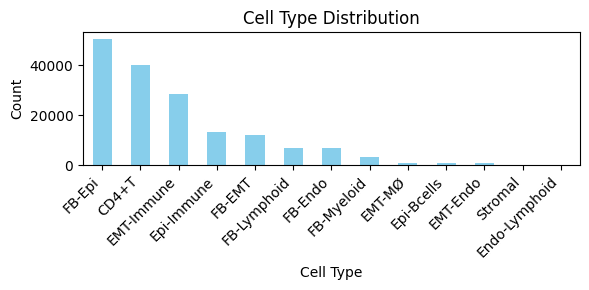

In [ ]:
cell_type_counts = adata_train.obs[key].value_counts()
plt.figure(figsize=(6, 3))
cell_type_counts.plot(kind='bar', color='skyblue')
plt.title("Cell Type Distribution")
plt.xlabel("Cell Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
if sparse.issparse(adata_train.X):
    adata_train.X = adata_train.X.tocsr().astype(np.float32)
else:
    X = np.asarray(adata_train.X, dtype=np.float32)
    # Replace non-finite values
    bad = ~np.isfinite(X)
    if bad.any():
        X[bad] = 0.0
    adata_train.X = X
if sparse.issparse(adata_test.X):
    adata_test.X = adata_test.X.tocsr().astype(np.float32)
else:
    Xte = np.asarray(adata_test.X, dtype=np.float32)
    Xte[~np.isfinite(Xte)] = 0.0
    adata_test.X = Xte
# do this so that google collab does not crash

In [ ]:
adata_train = SelfGraphConv(adata_train)
adata_test = SelfGraphConv(adata_test)

/usr/local/lib/python3.12/dist-packages/scipy/sparse/_index.py:201: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/usr/local/lib/python3.12/dist-packages/scipy/sparse/_index.py:201: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [ ]:
sc.pp.normalize_total(adata_train, target_sum=1e4)
sc.pp.log1p(adata_train)

sc.pp.normalize_total(adata_test, target_sum=1e4)
sc.pp.log1p(adata_test)

##CellTypist Method

In [ ]:
start = time.time()
my_model = celltypist.train(adata_train, key,alpha=1/(C*len(adata_train)), feature_selection=False, check_expression = True,use_SGD = True,mini_batch = True, batch_size=batch_size, batch_number=100)
end=time.time()
taken = end-start
print("training taken seconds: "+str(taken))

training taken seconds: 121.6477382183075


In [ ]:
start = time.time()
predictions = celltypist.annotate(adata_test, model = my_model,majority_voting = False,mode = 'best match')
end = time.time()
taken = end-start
print("testing taken seconds: "+str(taken))

testing taken seconds: 0.8541252613067627


In [ ]:
predicted_labels = predictions.predicted_labels.values
true_labels = adata_test.obs[key]
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

Accuracy: 0.7953836925390536


In [ ]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

       CD4+T       0.84      0.86      0.85     30162
    EMT-Endo       0.69      0.54      0.61       310
  EMT-Immune       0.84      0.91      0.87     24134
      EMT-MØ       0.93      0.65      0.76      1035
  Epi-Bcells       0.00      0.00      0.00         1
  Epi-Immune       0.91      0.77      0.83      9780
      FB-EMT       0.84      0.79      0.81      6765
     FB-Endo       0.26      0.21      0.23      1804
      FB-Epi       0.73      0.97      0.83     25364
 FB-Lymphoid       0.67      0.55      0.61      7198
  FB-Myeloid       0.76      0.45      0.57      8342
Mast-Stromal       0.00      0.00      0.00      3468

    accuracy                           0.80    118363
   macro avg       0.62      0.56      0.58    118363
weighted avg       0.77      0.80      0.78    118363



In [ ]:
y_refine = cKD_refine_label(np.array(adata_test.obsm['spatial']), predicted_labels, k = 50)
print("Accuracy:", accuracy_score(y_refine, true_labels))
print(classification_report(y_refine, predicted_labels))

Accuracy: 0.8561374753934929
              precision    recall  f1-score   support

       CD4+T       0.89      0.83      0.86     33146
    EMT-Endo       0.46      0.86      0.60       130
  EMT-Immune       0.89      0.89      0.89     26068
      EMT-MØ       0.89      0.68      0.77       937
  Epi-Bcells       0.00      0.00      0.00         0
  Epi-Immune       0.88      0.82      0.85      8754
      FB-EMT       0.85      0.80      0.83      6739
     FB-Endo       0.09      0.51      0.16       266
      FB-Epi       0.84      0.89      0.86     31846
 FB-Lymphoid       0.65      0.72      0.69      5300
  FB-Myeloid       0.71      0.68      0.69      5177

    accuracy                           0.84    118363
   macro avg       0.65      0.70      0.65    118363
weighted avg       0.85      0.84      0.85    118363



##Coreset Log Reg Methods

2025-10-21 00:02:54,260 - __main__ - INFO - done importing stuff
INFO:__main__:done importing stuff


In [ ]:
X_train = adata_train.X
y_train = adata_train.obs[key]
X_test = adata_test.X
y_test = adata_test.obs[key]

train_distribution = y_train.value_counts()
test_distribution = y_test.value_counts()

if not isinstance(X_train, csr_matrix):
    X_train = csr_matrix(X_train)

if not isinstance(X_test, csr_matrix):
    X_test = csr_matrix(X_test)

# Check for NaN values in X_train
if np.isnan(X_train.toarray()).any():
    logger.info("X_train contains NaN values.")

# Check for NaN values in y_train
if y_train.isnull().any():
    logger.info("y_train contains NaN values.")

coreset_ratio = [0.1]
coreset_size = []
for ratio in coreset_ratio:
    size = int(ratio*(X_train.shape[0]))
    coreset_size.append(size)

num_unique_cell_types = len(cell_type_counts)

for size in coreset_size:
    num_per_cell_type = int(size/num_unique_cell_types)
    # logger.info("for each cell type, we sample")
    # logger.info(num_per_cell_type)

    # logger.info("begin sampling")
    start = time.time()
    sampled_indices = celltypist.samples.downsample_adata(adata=adata_train, mode="each",n_cells=num_per_cell_type, by=key, random_state=42, return_index=True)
    #sampled_indices = np.random.choice(X_train.shape[0], size=size, replace=False)
    sampled_X_train = X_train[sampled_indices, :]
    sampled_y_train = y_train[sampled_indices]

    if np.isnan(sampled_X_train.toarray()).any():
        logger.info("X_train contains NaN values.")
    if sampled_y_train.isnull().any():
        logger.info("y_train contains NaN values.")

    if sampled_y_train.nunique() < 2:
        raise ValueError("y_train must contain at least two unique classes.")

    sampled_train_distribution = sampled_y_train.value_counts()

    gene_names = adata_test.var_names #test data gene names
    model_features = adata_train.var_names #train data gene names
    y_pred, clf, X_test_scaled, le = run_pipeline(adata_test,sampled_X_train,X_train, sampled_y_train,y_train, X_test,y_test, gene_names, model_features, resolution=0.5, min_prop=0.2, C = 0.01)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

training taken seconds: 5.840990304946899
Accuracy: 0.8135734984750302
              precision    recall  f1-score   support

       CD4+T       0.88      0.84      0.86     30162
    EMT-Endo       0.26      0.92      0.41       310
  EMT-Immune       0.92      0.84      0.88     24134
      EMT-MØ       0.59      0.94      0.73      1035
  Epi-Bcells       0.00      0.00      0.00         1
  Epi-Immune       0.87      0.82      0.84      9780
      FB-EMT       0.75      0.86      0.80      6765
     FB-Endo       0.23      0.51      0.32      1804
      FB-Epi       0.97      0.91      0.94     25364
 FB-Lymphoid       0.54      0.74      0.62      7198
  FB-Myeloid       0.64      0.75      0.69      8342
Mast-Stromal       0.00      0.00      0.00      3468

    accuracy                           0.81    118363
   macro avg       0.55      0.68      0.59    118363
weighted avg       0.82      0.81      0.81    118363



In [ ]:
y_refine = cKD_refine_label(np.array(adata_test.obsm['spatial']), y_pred, k = 50)
print("Accuracy:", accuracy_score(y_refine, y_test))
print(classification_report(y_refine, y_test))

Accuracy: 0.8893573160531585
              precision    recall  f1-score   support

       CD4+T       0.92      0.89      0.90     31139
    EMT-Endo       0.96      0.71      0.82       421
  EMT-Immune       0.94      0.97      0.96     23514
      EMT-MØ       1.00      0.71      0.83      1465
  Epi-Bcells       0.00      0.00      0.00         0
  Epi-Immune       0.88      0.98      0.93      8798
      FB-EMT       0.95      0.89      0.92      7230
     FB-Endo       0.58      0.50      0.53      2097
      FB-Epi       0.96      0.96      0.96     25389
 FB-Lymphoid       0.84      0.69      0.76      8721
  FB-Myeloid       0.83      0.72      0.77      9589
Mast-Stromal       0.00      0.00      0.00         0

    accuracy                           0.89    118363
   macro avg       0.74      0.67      0.70    118363
weighted avg       0.91      0.89      0.90    118363



##Random Forest Method

In [ ]:
run_ML(adata_train, adata_test)


🚀 Training: Random Forest


Building Random Forest:   0%|          | 0/5 [00:00<?, ?it/s]

  • 10/50 trees (this step: 153.3s)
  • 20/50 trees (this step: 151.6s)
  • 30/50 trees (this step: 152.3s)
  • 40/50 trees (this step: 153.4s)
  • 50/50 trees (this step: 152.7s)
⏳ Total training time: 763.3s

🔹 Random Forest Results:
Accuracy: 0.8134383210969645
              precision    recall  f1-score   support

       CD4+T       0.72      0.96      0.82     30162
    EMT-Endo       0.99      0.24      0.38       310
  EMT-Immune       0.84      0.89      0.87     24134
      EMT-MØ       0.87      0.73      0.79      1035
  Epi-Bcells       0.00      0.00      0.00         1
  Epi-Immune       0.96      0.77      0.85      9780
      FB-EMT       0.86      0.78      0.82      6765
     FB-Endo       0.45      0.42      0.43      1804
      FB-Epi       0.95      0.94      0.95     25364
 FB-Lymphoid       0.58      0.53      0.55      7198
  FB-Myeloid       0.88      0.45      0.59      8342
Mast-Stromal       0.00      0.00      0.00      3468

    accuracy                   

##GIN Method

In [ ]:
# import torch
# print(torch.__version__)
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
  # -f https://data.pyg.org/whl/torch-2.8.0+cu126.html

import torch
import torch_geometric
from torch_geometric.loader import DataLoader

print("Torch version:", torch.__version__)
print("PyG version:", torch_geometric.__version__)
print("✅ PyTorch Geometric successfully installed!")

Torch version: 2.8.0+cu126
PyG version: 2.7.0
✅ PyTorch Geometric successfully installed!


In [ ]:
adata_train.obsm['raw'] = adata_train.X
adata_test.obsm['raw'] = adata_test.X

label_key = 'niche'
X_feature = 'raw'
X_train = adata_train.obsm[X_feature]
y_train = adata_train.obs[label_key]
X_test = adata_test.obsm[X_feature]
y_test = adata_test.obs[label_key]

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors
import numpy as np
def build_knn_graph(adata, k=10, feature_key="X_pca", label_key=None, label_encoder=None):
    coords = adata.obsm["spatial"]

    # pick features
    if feature_key == "raw":
        features = adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X
    else:
        features = adata.obsm[feature_key]

    # build kNN graph
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(coords)
    _, indices = nbrs.kneighbors(coords)
    edge_index = []
    for i, neighs in enumerate(indices):
        for j in neighs[1:]:
            edge_index.append([i, j])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # features
    x = torch.tensor(features, dtype=torch.float)

    # labels (optional)
    y = None
    if label_key is not None:
        labels = adata.obs[label_key].values
        if label_encoder is not None:
            labels = label_encoder.transform(labels)
        y = torch.tensor(labels, dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y)


from sklearn.preprocessing import LabelEncoder
import numpy as np

def make_label_encoder(adata_train, adata_test, label_key):
    # take all labels from both datasets
    all_labels = np.concatenate([adata_train.obs[label_key].values,
                                 adata_test.obs[label_key].values])
    le = LabelEncoder()
    le.fit(all_labels)
    return le


le = make_label_encoder(adata_train, adata_test, label_key)


train_data = build_knn_graph(adata_train, k=5, feature_key="raw", label_key=label_key, label_encoder=le)
test_data = build_knn_graph(adata_test, k=5, feature_key="raw", label_key=label_key, label_encoder=le)


import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv
from torch_geometric.loader import NeighborLoader
from torch.nn import Linear, Sequential, ReLU

# --- Define GIN ---
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        nn1 = Sequential(Linear(in_channels, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        nn2 = Sequential(Linear(hidden_channels, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.conv1 = GINConv(nn1)
        self.conv2 = GINConv(nn2)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return x

# --- Build loaders ---
train_loader = NeighborLoader(
    train_data,
    num_neighbors=[15, 10],
    batch_size=128,
    shuffle=True
)

test_loader = NeighborLoader(
    test_data,
    num_neighbors=[15, 10],
    batch_size=128,
    shuffle=False
)


# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GIN(train_data.num_node_features, 64, train_data.y.max().item()+1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

start = time.time()
# --- Training ---
for epoch in range(20):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        # ✅ Only compute loss on seed nodes
        loss = F.cross_entropy(out[:batch.batch_size], batch.y[:batch.batch_size])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}")

end=time.time()
taken = end-start
print("training taken seconds: "+str(taken))


from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)

        out = model(batch.x, batch.edge_index)  # logits
        preds = out[:batch.batch_size].argmax(dim=1).cpu().numpy()
        labels = batch.y[:batch.batch_size].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

# Now compute metrics
print("Accuracy:", accuracy_score(all_labels, all_preds))
# print("F1-score (macro):", f1_score(all_labels, all_preds, average="macro"))
# print("F1-score (weighted):", f1_score(all_labels, all_preds, average="weighted"))
print("\nClassification report:\n", classification_report(all_labels, all_preds, zero_division=0))

Epoch 0, Loss: 0.4436
Epoch 1, Loss: 0.2802
Epoch 2, Loss: 0.2736
Epoch 3, Loss: 0.2702
Epoch 4, Loss: 0.2808
Epoch 5, Loss: 0.5729
Epoch 6, Loss: 0.4105
Epoch 7, Loss: 0.3780
Epoch 8, Loss: 0.3676
Epoch 9, Loss: 0.3406
Epoch 10, Loss: 0.3434
Epoch 11, Loss: 0.3705
Epoch 12, Loss: 0.3672
Epoch 13, Loss: 0.3475
Epoch 14, Loss: 0.3615
Epoch 15, Loss: 0.4131
Epoch 16, Loss: 0.3455
Epoch 17, Loss: 0.3277
Epoch 18, Loss: 0.3328
Epoch 19, Loss: 0.3981
training taken seconds: 462.24536061286926
Accuracy: 0.7624764495661651

Classification report:
               precision    recall  f1-score   support

           0       0.65      0.92      0.76     30162
           1       0.00      0.00      0.00       310
           2       0.74      0.95      0.83     24134
           3       0.38      0.70      0.49      1035
           5       0.00      0.00      0.00         1
           6       0.93      0.87      0.90      9780
           7       0.85      0.86      0.86      6765
           8       0

#Nanostring Dataset

In [ ]:
# data source - train: https://drive.google.com/file/d/1p0VhWBAQjFCzAES0a9TeWqvc-DT2y5OA/view?usp=drive_link
# data source - test: https://drive.google.com/file/d/1v1IJx74Lexii22jONGsuTUycY9iw99-x/view?usp=drive_link
adata_train = anndata.read_h5ad("/content/drive/MyDrive/nanostring_cosmx_human_nsclc_batch1.h5ad")
adata_test = anndata.read_h5ad("/content/drive/MyDrive/nanostring_cosmx_human_nsclc_batch3.h5ad")

In [ ]:
np.shape(adata_train), np.shape(adata_test)

((93206, 960), (91691, 960))

In [ ]:
if sparse.issparse(adata_train.X):
    adata_train.X = adata_train.X.tocsr().astype(np.float32)
else:
    X = np.asarray(adata_train.X, dtype=np.float32)
    # Replace non-finite values
    bad = ~np.isfinite(X)
    if bad.any():
        X[bad] = 0.0
    adata_train.X = X
if sparse.issparse(adata_test.X):
    adata_test.X = adata_test.X.tocsr().astype(np.float32)
else:
    Xte = np.asarray(adata_test.X, dtype=np.float32)
    Xte[~np.isfinite(Xte)] = 0.0
    adata_test.X = Xte
# do this so that google collab does not crash

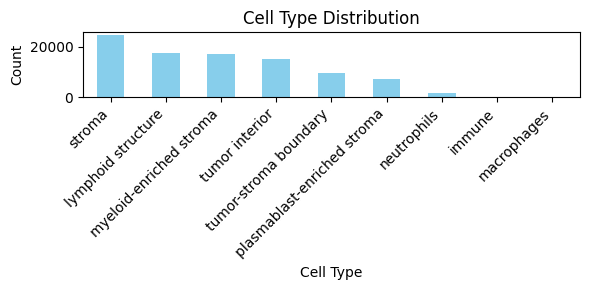

In [ ]:
key = 'niche'
cell_type_counts = adata_train.obs[key].value_counts()
plt.figure(figsize=(6, 3))
cell_type_counts.plot(kind='bar', color='skyblue')
plt.title("Cell Type Distribution")
plt.xlabel("Cell Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
adata_train = SelfGraphConv(adata_train)
adata_test = SelfGraphConv(adata_test)

In [ ]:
sc.pp.normalize_total(adata_train, target_sum=1e4)
sc.pp.log1p(adata_train)

sc.pp.normalize_total(adata_test, target_sum=1e4)
sc.pp.log1p(adata_test)

##CellTypist Method

In [ ]:
start = time.time()
my_model = celltypist.train(adata_train, key,alpha=1/(C*len(adata_train)), feature_selection=False, check_expression = True,use_SGD = True,mini_batch = True, batch_size=batch_size, batch_number=100)
end=time.time()
taken = end-start
print("training taken seconds: "+str(taken))

start = time.time()
predictions = celltypist.annotate(adata_test, model = my_model,majority_voting = False,mode = 'best match')
end = time.time()
taken = end-start
print("testing taken seconds: "+str(taken))

predicted_labels = predictions.predicted_labels.values
true_labels = adata_test.obs[key]
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

print(classification_report(true_labels, predicted_labels))

training taken seconds: 98.80811810493469
testing taken seconds: 3.2596981525421143
Accuracy: 0.6081294783566544
                             precision    recall  f1-score   support

                     immune       0.00      0.00      0.00       292
         lymphoid structure       0.83      0.71      0.77     21050
                macrophages       0.00      0.00      0.00         3
    myeloid-enriched stroma       0.83      0.55      0.66     18151
                neutrophils       0.21      0.07      0.10       882
plasmablast-enriched stroma       0.52      0.31      0.39      7867
                     stroma       0.41      0.77      0.54     22099
             tumor interior       0.83      0.70      0.76     13307
      tumor-stroma boundary       0.47      0.25      0.33      8040

                   accuracy                           0.61     91691
                  macro avg       0.46      0.37      0.39     91691
               weighted avg       0.66      0.61      0.6

In [ ]:
y_refine = cKD_refine_label(np.array(adata_test.obsm['spatial']), predicted_labels, k = 50)
print("Accuracy:", accuracy_score(y_refine, true_labels))
print(classification_report(y_refine, predicted_labels))

Accuracy: 0.6895224176854872
                             precision    recall  f1-score   support

         lymphoid structure       0.82      0.80      0.81     18544
    myeloid-enriched stroma       0.73      0.72      0.72     11995
                neutrophils       0.04      0.52      0.08        23
plasmablast-enriched stroma       0.26      0.56      0.36      2215
                     stroma       0.76      0.71      0.73     44125
             tumor interior       0.87      0.75      0.81     12892
      tumor-stroma boundary       0.22      0.50      0.31      1897

                   accuracy                           0.73     91691
                  macro avg       0.53      0.65      0.55     91691
               weighted avg       0.76      0.73      0.74     91691



##Coreset Log Reg Method

In [ ]:
X_train = adata_train.X
y_train = adata_train.obs[key]
X_test = adata_test.X
y_test = adata_test.obs[key]


if sparse.issparse(X_train):
    X_train = X_train.tocsr().astype(np.float32)
else:
    X = np.asarray(X_train, dtype=np.float32)
    # Replace non-finite values
    bad = ~np.isfinite(X)
    if bad.any():
        X[bad] = 0.0
    X_train = X
if sparse.issparse(X_test):
    X_test = X_test.tocsr().astype(np.float32)
else:
    Xte = np.asarray(X_test, dtype=np.float32)
    Xte[~np.isfinite(Xte)] = 0.0
    X_test = Xte
# do this so that google collab does not crash

train_distribution = y_train.value_counts()
test_distribution = y_test.value_counts()

if not isinstance(X_train, csr_matrix):
    X_train = csr_matrix(X_train)

if not isinstance(X_test, csr_matrix):
    X_test = csr_matrix(X_test)

# Check for NaN values in X_train
if np.isnan(X_train.toarray()).any():
    logger.info("X_train contains NaN values.")

# Check for NaN values in y_train
if y_train.isnull().any():
    logger.info("y_train contains NaN values.")

coreset_ratio = [0.1]
coreset_size = []
for ratio in coreset_ratio:
    size = int(ratio*(X_train.shape[0]))
    coreset_size.append(size)

num_unique_cell_types = len(cell_type_counts)

for size in coreset_size:
    num_per_cell_type = int(size/num_unique_cell_types)
    # logger.info("for each cell type, we sample")
    # logger.info(num_per_cell_type)

    # logger.info("begin sampling")
    start = time.time()
    sampled_indices = celltypist.samples.downsample_adata(adata=adata_train, mode="each",n_cells=num_per_cell_type, by=key, random_state=42, return_index=True)
    #sampled_indices = np.random.choice(X_train.shape[0], size=size, replace=False)
    sampled_X_train = X_train[sampled_indices, :]
    sampled_y_train = y_train[sampled_indices]

    if np.isnan(sampled_X_train.toarray()).any():
        logger.info("X_train contains NaN values.")
    if sampled_y_train.isnull().any():
        logger.info("y_train contains NaN values.")

    if sampled_y_train.nunique() < 2:
        raise ValueError("y_train must contain at least two unique classes.")

    sampled_train_distribution = sampled_y_train.value_counts()

    gene_names = adata_test.var_names #test data gene names
    model_features = adata_train.var_names #train data gene names
    y_pred, clf, X_test_scaled, le = run_pipeline(adata_test,sampled_X_train,X_train, sampled_y_train,y_train, X_test,y_test, gene_names, model_features, resolution=0.5, min_prop=0.2, C = 0.01)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

training taken seconds: 5.516927719116211
Accuracy: 0.6125464876596395
                             precision    recall  f1-score   support

                     immune       0.02      0.00      0.01       292
         lymphoid structure       0.78      0.74      0.76     21050
                macrophages       0.00      0.00      0.00         3
    myeloid-enriched stroma       0.80      0.65      0.72     18151
                neutrophils       0.08      0.42      0.14       882
plasmablast-enriched stroma       0.33      0.54      0.41      7867
                     stroma       0.60      0.49      0.54     22099
             tumor interior       0.81      0.74      0.77     13307
      tumor-stroma boundary       0.37      0.44      0.40      8040

                   accuracy                           0.61     91691
                  macro avg       0.42      0.45      0.42     91691
               weighted avg       0.66      0.61      0.63     91691



In [ ]:
y_refine = cKD_refine_label(np.array(adata_test.obsm['spatial']), y_pred, k = 50)
print("Accuracy:", accuracy_score(y_refine, y_test))
print(classification_report(y_refine, y_test))

Accuracy: 0.7681997142576698
                             precision    recall  f1-score   support

                     immune       0.00      0.00      0.00         0
         lymphoid structure       0.89      0.86      0.88     21740
                macrophages       0.00      0.00      0.00         0
    myeloid-enriched stroma       0.87      0.88      0.88     17891
                neutrophils       0.57      0.25      0.35      2000
plasmablast-enriched stroma       0.77      0.48      0.59     12564
                     stroma       0.59      0.82      0.68     15925
             tumor interior       0.87      0.86      0.87     13464
      tumor-stroma boundary       0.59      0.59      0.59      8107

                   accuracy                           0.77     91691
                  macro avg       0.57      0.53      0.54     91691
               weighted avg       0.78      0.77      0.77     91691



##Random Forest Method

In [ ]:
run_ML(adata_train, adata_test)


🚀 Training: Random Forest


Building Random Forest:   0%|          | 0/5 [00:00<?, ?it/s]

  • 10/50 trees (this step: 125.5s)
  • 20/50 trees (this step: 120.9s)
  • 30/50 trees (this step: 122.0s)
  • 40/50 trees (this step: 121.5s)
  • 50/50 trees (this step: 121.5s)
⏳ Total training time: 611.4s

🔹 Random Forest Results:
Accuracy: 0.667306496820844
                             precision    recall  f1-score   support

                     immune       0.00      0.00      0.00       292
         lymphoid structure       0.82      0.73      0.77     21050
                macrophages       0.00      0.00      0.00         3
    myeloid-enriched stroma       0.77      0.74      0.75     18151
                neutrophils       0.11      0.00      0.00       882
plasmablast-enriched stroma       0.63      0.22      0.33      7867
                     stroma       0.51      0.80      0.62     22099
             tumor interior       0.77      0.85      0.81     13307
      tumor-stroma boundary       0.52      0.22      0.31      8040

                   accuracy                 

##GIN Method

In [ ]:
# import torch
# print(torch.__version__)
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
  # -f https://data.pyg.org/whl/torch-2.8.0+cu126.html

import torch
import torch_geometric
from torch_geometric.loader import DataLoader

print("Torch version:", torch.__version__)
print("PyG version:", torch_geometric.__version__)
print("✅ PyTorch Geometric successfully installed!")

In [ ]:
adata_train.obsm['raw'] = adata_train.X
adata_test.obsm['raw'] = adata_test.X

label_key = 'niche'
X_feature = 'raw'
X_train = adata_train.obsm[X_feature]
y_train = adata_train.obs[label_key]
X_test = adata_test.obsm[X_feature]
y_test = adata_test.obs[label_key]

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors
import numpy as np
def build_knn_graph(adata, k=10, feature_key="X_pca", label_key=None, label_encoder=None):
    coords = adata.obsm["spatial"]

    # pick features
    if feature_key == "raw":
        features = adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X
    else:
        features = adata.obsm[feature_key]

    # build kNN graph
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(coords)
    _, indices = nbrs.kneighbors(coords)
    edge_index = []
    for i, neighs in enumerate(indices):
        for j in neighs[1:]:
            edge_index.append([i, j])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # features
    x = torch.tensor(features, dtype=torch.float)

    # labels (optional)
    y = None
    if label_key is not None:
        labels = adata.obs[label_key].values
        if label_encoder is not None:
            labels = label_encoder.transform(labels)
        y = torch.tensor(labels, dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y)


from sklearn.preprocessing import LabelEncoder
import numpy as np

def make_label_encoder(adata_train, adata_test, label_key):
    # take all labels from both datasets
    all_labels = np.concatenate([adata_train.obs[label_key].values,
                                 adata_test.obs[label_key].values])
    le = LabelEncoder()
    le.fit(all_labels)
    return le


le = make_label_encoder(adata_train, adata_test, label_key)


train_data = build_knn_graph(adata_train, k=5, feature_key="raw", label_key=label_key, label_encoder=le)
test_data = build_knn_graph(adata_test, k=5, feature_key="raw", label_key=label_key, label_encoder=le)


import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv
from torch_geometric.loader import NeighborLoader
from torch.nn import Linear, Sequential, ReLU

# --- Define GIN ---
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        nn1 = Sequential(Linear(in_channels, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        nn2 = Sequential(Linear(hidden_channels, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.conv1 = GINConv(nn1)
        self.conv2 = GINConv(nn2)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return x

# --- Build loaders ---
train_loader = NeighborLoader(
    train_data,
    num_neighbors=[15, 10],
    batch_size=128,
    shuffle=True
)

test_loader = NeighborLoader(
    test_data,
    num_neighbors=[15, 10],
    batch_size=128,
    shuffle=False
)


# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GIN(train_data.num_node_features, 64, train_data.y.max().item()+1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

start = time.time()
# --- Training ---
for epoch in range(20):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        # ✅ Only compute loss on seed nodes
        loss = F.cross_entropy(out[:batch.batch_size], batch.y[:batch.batch_size])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}")

end=time.time()
taken = end-start
print("training taken seconds: "+str(taken))


from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)

        out = model(batch.x, batch.edge_index)  # logits
        preds = out[:batch.batch_size].argmax(dim=1).cpu().numpy()
        labels = batch.y[:batch.batch_size].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

# Now compute metrics
print("Accuracy:", accuracy_score(all_labels, all_preds))
# print("F1-score (macro):", f1_score(all_labels, all_preds, average="macro"))
# print("F1-score (weighted):", f1_score(all_labels, all_preds, average="weighted"))
print("\nClassification report:\n", classification_report(all_labels, all_preds, zero_division=0))

Epoch 0, Loss: 1.0534
Epoch 1, Loss: 0.7285
Epoch 2, Loss: 0.6497
Epoch 3, Loss: 0.6227
Epoch 4, Loss: 0.5874
Epoch 5, Loss: 0.5645
Epoch 6, Loss: 0.6041
Epoch 7, Loss: 0.6695
Epoch 8, Loss: 0.5803
Epoch 9, Loss: 0.5688
Epoch 10, Loss: 0.5395
Epoch 11, Loss: 0.5316
Epoch 12, Loss: 0.5204
Epoch 13, Loss: 0.5216
Epoch 14, Loss: 0.5387
Epoch 15, Loss: 0.7130
Epoch 16, Loss: 0.6648
Epoch 17, Loss: 0.6389
Epoch 18, Loss: 0.6374
Epoch 19, Loss: 0.6150
training taken seconds: 443.4386639595032
Accuracy: 0.651328919959429

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       292
           1       0.83      0.78      0.80     21050
           2       0.00      0.00      0.00         3
           3       0.87      0.60      0.71     18151
           4       0.00      0.00      0.00       882
           5       0.46      0.41      0.43      7867
           6       0.50      0.65      0.57     22099
           7       0.7